In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
from pprint import pprint
%matplotlib inline

In [2]:
# From https://github.com/naokishibuya/car-finding-lane-lines/blob/master/Finding%20Lane%20Lines%20on%20the%20Road.ipynb
def show_images(images, cols=2, cmap=None):
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10,11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        cmap = "gray" if len(image.shape) == 2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

In [3]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

## Camera Calibration
Cameras often have some distortion that will effect the perception of size and distance.
Therefore, the first step before using images for data is calibration to correct this distortion

In [4]:
images = [plt.imread(name) for name in glob.glob("camera_cal/*.jpg")]

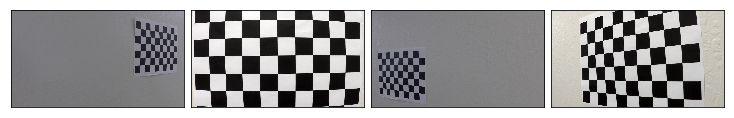

In [5]:
show_images(images[:4], cols=4)

In [6]:
def calibrate_camera(images):
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    objpoints = []
    imgpoints = []
    
    for image in images:
        gray = grayscale(image)
        
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return ret, mtx, dist, rvecs, tvecs
    
ret, mtx, dist, rvecs, tvecs = calibrate_camera(images)

In [7]:
images = list(map(lambda image: cv2.undistort(image, mtx, dist, None, mtx), images))

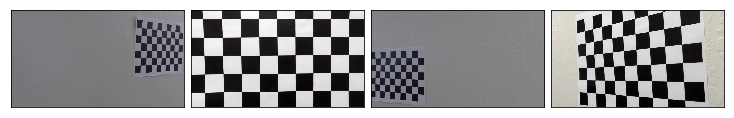

In [8]:
show_images(images[:4], cols=4)

## Pipeline

- Undistort